<a href="https://colab.research.google.com/github/rashikshrestha/SOM_MNIST/blob/main/SOMS_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import all the necessary dependency
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import plotly.graph_objects as go

# Data Preprocessing

In [ ]:
#read the MNIST train data
#the csv file is expected...mnist vsc was taken as provided by colab 
data = pd.read_csv('/content/sample_data/mnist_train_small.csv')

#taking random 500 images for train
data = data.sample(n=500, random_state=0)

#saving the labesls of image
labels = data[data.columns[0]]

#remove the labels from training data (unsupervised)
X = data.drop(data.columns[0], axis=1)

#normalize the data
Xnorm = np.array(X/255.0)

print("Shape of training data:", Xnorm.shape, " Total Images:", Xnorm.shape[0])

Shape of training data: (500, 784)  Total Images: 500


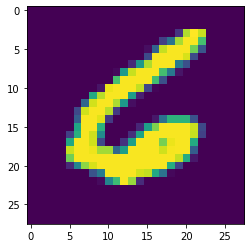

In [ ]:
#check one of the image in index 0
plt.imshow(Xnorm[0].reshape(28,28))

In [ ]:
#Histogram for class distributions (how many image are there for each class)
def count_elements(seq):
  hist = {}
  for i in seq:
      hist[i] = hist.get(i, 0) + 1
  return hist

t = count_elements(labels)
print(t)

{6: 55, 4: 54, 0: 48, 5: 47, 1: 44, 2: 53, 7: 42, 3: 59, 8: 51, 9: 47}


# Initilize the map

In [ ]:
#let the size of map be 40x40
map_h, map_w = 40, 40

#each node in 40x40 map has weight vector
# shape equal to inputfeature shape (784)
inputFeatureShape = Xnorm[0].shape[0]

#initialize the map of shape 40x40x784
map = np.random.rand(map_h, map_w, inputFeatureShape)

#conform the shape
print("Map shape: ", map.shape)

Map shape:  (40, 40, 784)


# Visualize untrained map

In [ ]:
def visualizeMap(map):

  #generate x,y,z for plot, x and y are all possbile 2d grid and z is the l2 of map value
  xs = np.array([])
  ys = np.array([])
  zs = np.array([])
  for x in range(map.shape[0]):
    for y in range(map.shape[1]):
      # print(x,y)
      xs = np.append(xs, x)
      ys = np.append(ys, y)
      zs_t = np.linalg.norm(map[x][y]) 
      zs = np.append(zs, zs_t)

  x = xs
  y = ys
  z = zs

  fig = go.Figure(data=[go.Scatter3d(
      x=x,
      y=y,
      z=z,
      mode='markers',
      marker=dict(
          size=5,
          color=z,                # set color to an array/list of desired values
          colorscale='Viridis',   # choose a colorscale
          opacity=0.8
      )
  )])

  fig.update_xaxes(
        title_text = "Month",
        title_font = {"size": 20},
        title_standoff = 25)

  fig.update_yaxes(
          title_text = "Temperature",
          title_font = {"size": 20},
          title_standoff = 25)
  

  # tight layout
  fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
  fig.show()


In [ ]:
visualizeMap(map)

# Load map from files

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
map = np.load("/gdrive/MyDrive/SOMS presentation/map_1000.npy")

In [ ]:
map_h, map_w = map.shape[:2]

# Learning Rate

Text(0.5, 1.0, 'Visualize the Learning rate decay')

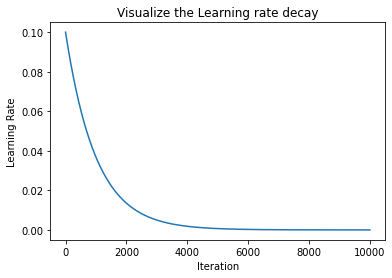

In [ ]:
#learning rate 
def learningRate(i, constant = 1000, initialrate = 0.1):
  alpha = initialrate * np.exp(-(i)/(constant))
  return alpha

#Visualize the Learning rate decay
rates = [learningRate(i) for i in range(10000)]
plt.plot(rates)
plt.xlabel("Iteration")
plt.ylabel("Learning Rate")
plt.title("Visualize the Learning rate decay")

# Neighbourhood Size defination

Text(0.5, 1.0, 'Visualize the Neighbhood size decay')

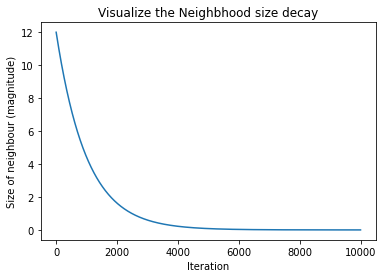

In [ ]:
#neighbourhood size
def neighbourhoodSize(i, constant = 1000, initalValue = 3*map_h/(len(t.keys()))):
  v = initalValue * np.exp(-(i)/(constant))
  return v

Nsize = [neighbourhoodSize(i) for i in range(10000)]
plt.plot(Nsize)
plt.xlabel("Iteration")
plt.ylabel("Size of neighbour (magnitude)")
plt.title("Visualize the Neighbhood size decay")

# topographicalNeighborhoodFactor (hij) [range (0, 1)]

In [ ]:
#first lest initialize template for physical distance for 2d
#template vector has shape 40x40x2 (shape of lattice x 2d cordinate)
#tempate is vector with element value equal to index/cordinate of node(x,y) == (i,j)
template = np.zeros((map.shape[0], map.shape[1], (len(map.shape) -1)))
for x in range(template.shape[0]):
  for y in range(template.shape[1]):
    template[x][y][0] = x 
    template[x][y][1] = y

def topographicalNeighborhood(i, winningNeuronIndex, neuronJIndex = template):
  lateral_distance = np.linalg.norm(neuronJIndex - winningNeuronIndex, axis = 2)
  sigma = neighbourhoodSize(i)
  hij = np.exp(-(np.square(lateral_distance))/(2*(sigma**2)))

  #tn is a vector of shape 40x40 (shape of lattice) 
  # where each element is a neighbourhood value (higher value indicate closer neighbhour) 
  return hij

In [ ]:
#visualize hij
topoNeighborFactor = topographicalNeighborhood(i = 500, winningNeuronIndex = [20,20])
visualizeMap(topoNeighborFactor)

# Training

In [ ]:
#set total epoch to be trained
totalEpoch = 1000
for epoch in tqdm(range(totalEpoch)):
  #lr decays for each epoch
  lr = learningRate(epoch)
  #iterate over the training data
  for x_it in Xnorm:

    #competation 
    d = np.linalg.norm((map - x_it), axis = 2)
    winningNeuronIndex = np.unravel_index(np.argmin(d, axis=None), d.shape)

    #coperation
    hij = topographicalNeighborhood(i = epoch, winningNeuronIndex = winningNeuronIndex)

    #Update weights
    delWeight = lr * hij[:,:,None] * (x_it - map)
    map = map + delWeight

# Save the map/model

In [ ]:
np.save('map_1000', map) 

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
!cp '/content/map_1000.npy' '/gdrive/MyDrive/SOMS presentation/map_1000.npy'

# Vissualize trained map

In [ ]:
visualizeMap(map)

# Inferrence on some trainingset

In [ ]:
unique_labels = list(set(labels))
dataIndex = dict()
for label in unique_labels:
  indices = [i for i, x in enumerate(labels) if x == label]
  dataIndex[label] = indices
print(dataIndex)
#dataindex -> dict with keys (name of class eg. 0, 1,2,.. 9) and value are indexes in Xnorm that correspond to the class

{0: [2, 11, 16, 24, 27, 46, 67, 72, 77, 79, 82, 87, 93, 123, 146, 169, 186, 190, 205, 223, 227, 241, 252, 258, 262, 264, 268, 273, 277, 293, 296, 319, 321, 332, 335, 338, 344, 349, 351, 378, 387, 399, 434, 450, 465, 470, 472, 496], 1: [6, 15, 26, 31, 56, 59, 60, 65, 69, 75, 98, 107, 113, 117, 118, 120, 122, 125, 137, 145, 149, 159, 163, 165, 195, 198, 200, 202, 212, 237, 261, 274, 302, 308, 339, 362, 370, 394, 395, 396, 428, 446, 485, 495], 2: [7, 23, 42, 50, 55, 61, 63, 68, 76, 95, 106, 115, 124, 148, 153, 160, 164, 166, 178, 179, 185, 187, 199, 208, 230, 240, 278, 283, 295, 304, 327, 328, 330, 342, 345, 367, 374, 376, 384, 400, 404, 412, 415, 422, 432, 438, 448, 451, 462, 464, 473, 494, 497], 3: [10, 12, 19, 22, 30, 32, 34, 58, 80, 89, 101, 108, 110, 112, 116, 126, 135, 143, 151, 156, 167, 171, 207, 218, 220, 228, 229, 238, 243, 244, 251, 270, 275, 281, 291, 306, 315, 320, 324, 347, 356, 365, 385, 391, 392, 398, 425, 426, 430, 439, 445, 452, 454, 479, 483, 487, 488, 489, 491], 4: [1,

In [ ]:
#index <- dataIndex[class][numbered class image]
#Here we are selecting the 1st (0th) image of '0' 
idx = dataIndex[0][0]
test = Xnorm[idx]

#competation
d = np.linalg.norm((map - test), axis = 2)
winningNeuronIndex = np.unravel_index(np.argmin(d, axis=None), d.shape)

#here z axis is the inverese of differnce between input (test) and weights
visualizeMap(1/d)

winning node:  (26, 0)


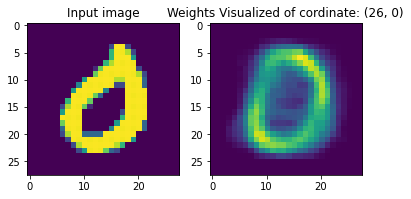

In [ ]:
#print the cordinates to winning neuron
print("winning node: ", winningNeuronIndex)


#show the input image
plt.subplot(1, 2, 1)
plt.title("Input image")
plt.imshow(test.reshape(28,28))

#visualize the weight vector of winning neuron as a 28x28image
node_Image = map[winningNeuronIndex].reshape(28,28)
plt.subplot(1, 2, 2)
plt.title("Weights Visualized of cordinate: " + str(winningNeuronIndex))
plt.imshow(node_Image)

# Clustering & visualization on test MNIST data


In [ ]:
testdata = pd.read_csv('/content/sample_data/mnist_train_small.csv')
testdata = testdata.sample(n=5000, random_state=0)
# testdata.head()
test_labels = testdata[testdata.columns[0]]
Xtest = testdata.drop(testdata.columns[0], axis=1)

XnormTest = np.array(Xtest/255.0)

test_hist = count_elements(test_labels)
print(test_hist)


{6: 535, 4: 467, 0: 470, 5: 434, 1: 536, 2: 512, 7: 508, 3: 518, 8: 509, 9: 511}


In [ ]:
unique_labels = list(set(test_labels))
testdataIndex = dict()
for label in unique_labels:
  indices = [i for i, x in enumerate(test_labels) if x == label]
  testdataIndex[label] = indices
print(testdataIndex)

{0: [2, 11, 16, 24, 27, 46, 67, 72, 77, 79, 82, 87, 93, 123, 146, 169, 186, 190, 205, 223, 227, 241, 252, 258, 262, 264, 268, 273, 277, 293, 296, 319, 321, 332, 335, 338, 344, 349, 351, 378, 387, 399, 434, 450, 465, 470, 472, 496, 529, 589, 607, 608, 611, 644, 657, 660, 673, 683, 698, 715, 738, 745, 753, 758, 759, 770, 787, 821, 836, 848, 861, 893, 894, 901, 902, 909, 915, 928, 932, 934, 945, 950, 957, 960, 986, 1006, 1024, 1031, 1089, 1096, 1097, 1098, 1105, 1120, 1124, 1143, 1146, 1147, 1149, 1153, 1165, 1178, 1224, 1239, 1244, 1248, 1272, 1276, 1284, 1290, 1302, 1327, 1335, 1345, 1350, 1365, 1374, 1389, 1391, 1393, 1397, 1399, 1401, 1423, 1429, 1431, 1439, 1449, 1457, 1459, 1461, 1485, 1497, 1504, 1518, 1521, 1528, 1530, 1540, 1549, 1565, 1575, 1582, 1587, 1593, 1598, 1607, 1625, 1646, 1671, 1680, 1694, 1698, 1705, 1719, 1754, 1755, 1757, 1758, 1759, 1763, 1765, 1768, 1779, 1780, 1782, 1787, 1791, 1794, 1815, 1831, 1851, 1862, 1863, 1867, 1897, 1904, 1912, 1913, 1914, 1917, 1943, 19

In [ ]:
all_winningNeuronIndexTest = dict()
for iclass in testdataIndex.keys():
  indexStore = []
  for test_index in testdataIndex[iclass]:
    d = np.linalg.norm((map - XnormTest[test_index]), axis = 2)
    winningNeuronIndex = np.unravel_index(np.argmin(d, axis=None), d.shape)
    indexStore.append(winningNeuronIndex)

  all_winningNeuronIndexTest[iclass] = indexStore

print(all_winningNeuronIndexTest)


{0: [(26, 0), (39, 0), (39, 5), (28, 0), (39, 6), (39, 7), (39, 7), (39, 0), (37, 0), (26, 0), (39, 1), (39, 4), (39, 8), (35, 0), (39, 6), (5, 28), (29, 0), (39, 5), (39, 7), (39, 8), (39, 7), (30, 0), (33, 0), (39, 0), (28, 0), (39, 4), (28, 0), (32, 0), (31, 7), (39, 6), (22, 24), (37, 0), (35, 0), (39, 0), (13, 7), (35, 6), (24, 0), (33, 0), (27, 0), (39, 8), (39, 7), (33, 0), (36, 0), (39, 0), (31, 0), (29, 0), (33, 0), (29, 0), (37, 6), (39, 0), (31, 0), (30, 0), (35, 0), (34, 0), (20, 3), (39, 12), (39, 5), (39, 4), (39, 8), (26, 0), (36, 0), (0, 32), (28, 0), (30, 0), (33, 3), (34, 0), (33, 6), (39, 12), (22, 4), (21, 4), (29, 0), (35, 0), (39, 6), (39, 7), (23, 5), (31, 0), (39, 0), (39, 0), (35, 0), (23, 1), (39, 7), (28, 3), (39, 6), (28, 0), (39, 0), (39, 0), (32, 0), (30, 0), (28, 0), (31, 0), (37, 0), (39, 6), (39, 9), (39, 0), (32, 0), (32, 0), (37, 0), (39, 5), (39, 0), (37, 0), (27, 0), (39, 8), (36, 10), (25, 1), (22, 1), (39, 2), (39, 4), (23, 1), (24, 0), (30, 3), (

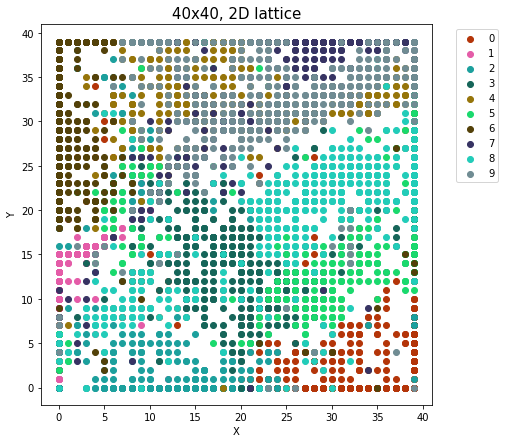

In [ ]:
color = ['#b43509', '#e45ca8','#1ca09d','#166559','#96750a','#1ad96d','#534109','#373363','#22ccb9','#708c93']

plt.figure(figsize=(7,7))
for iclass in all_winningNeuronIndexTest.keys():
  # print(all_winningNeuronIndexTest[iclass])
  x = (np.array(all_winningNeuronIndexTest[iclass]))[:,0]
  y = (np.array(all_winningNeuronIndexTest[iclass]))[:,1]

  plt.scatter(x, y, c = color[int(iclass)], label=str(iclass))

plt.legend(bbox_to_anchor=(1.05, 1))

plt.title("40x40, 2D lattice", fontsize = 15)
plt.xlabel("X")
plt.ylabel("Y")

plt.savefig('nodes.png', dpi=150, bbox_inches='tight',  transparent=False)
plt.show()